In [1]:
!pip install EoN

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statistics
import sys
import random
import math
import EoN
import numpy as np
import powerlaw
import pandas as pd
import seaborn as sns
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
from scipy.stats import norm
from termcolor import colored, cprint
from matplotlib.patches import Rectangle

In [3]:
MORENO_RESIDENCE_HALL_FILE = 'networks/moreno_residence_hall.txt'

# Residence-Hall-Network

(Directed)

This directed network contains friendship ratings between 217 residents living at a residence hall located on the Australian National University campus. A node represents a person and 
an edge represents a friendship tie.  The friendships are weighted as follows from strongest to weakest tie:  5 (best friend), 4 (close friend), 3 (friend), 2, 1.

In [4]:
G = nx.read_weighted_edgelist(MORENO_RESIDENCE_HALL_FILE, create_using= nx.DiGraph, nodetype=int)
cprint(nx.info(G),'green')

Name: 
Type: DiGraph
Number of nodes: 217
Number of edges: 2672
Average in degree:  12.3134
Average out degree:  12.3134


In [5]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
nodes = G.nodes()
edges = G.edges()

# Utility functions

In [6]:
def check_small_wordl(G_truth,G):
    #average shoart path length (for small world property)
    avg_short_path = nx.average_shortest_path_length(G_truth)
    avg_short_path_G = nx.average_shortest_path_length(G)
    cprint("Average shortest path length Original network: ", 'blue', end=' ')
    cprint(round(avg_short_path,2), 'green')
    cprint("Average shortest path length Random network: ", 'blue', end=' ')
    cprint(round(avg_short_path_G,2), 'green')


    if(math.isclose(math.log(G.number_of_nodes(),10),avg_short_path,abs_tol=0.5)):
        cprint("Small-wordl", 'yellow')
    else:
        cprint("NOT Small-wordl ", 'yellow')

    avg_clustering = nx.average_clustering(G_truth)
    avg_clustering_G = nx.average_clustering(G)
    cprint("Average Clustering Original Network: ", 'blue', end=' ')
    cprint(round(avg_clustering,2), 'green')
    cprint("Average Clustering Random network:", 'blue', end=' ')
    cprint(round(avg_clustering_G,2), 'green')


In [7]:
def draw_graph(G,pos):
    plt.figure(figsize = (100, 100))
    nx.draw(G,node_color='#add8e6', node_size=8000,arrowsize=40, width=2.0, pos=pos)
    nx.draw_networkx_labels(G, font_size=30, pos=pos)
    plt.plot()

In [8]:
def get_degrees_sequences(G,directed):
     if(directed):
          return {'Degree sequence':[G.degree(n) for n in G.nodes],
          'In degree sequence':[G.in_degree(n) for n in G.nodes],
          'Out degree sequence':[G.out_degree(n) for n in G.nodes]}
     else:
          return {'Degree sequence':[G.degree(n) for n in G.nodes]}     

In [9]:
def print_degree_statistics(G,directed):
    degree_sequence = get_degrees_sequences(G,directed)['Degree sequence']
    mu_degree = statistics.mean(degree_sequence)
    median_degree = statistics.median(degree_sequence)
    variance_degree = statistics.variance(degree_sequence)
    sigma_degree = statistics.stdev(degree_sequence)
    cprint('Mean degree:', 'blue', end=' ') 
    cprint(mu_degree, 'green')
    cprint('Median degree:','blue', end=' ') 
    cprint(median_degree, 'green')
    cprint('Max degree:', 'blue', end=' ')
    cprint(max(degree_sequence), 'green')
    cprint('Variance:', 'blue', end=' ')
    cprint(variance_degree, 'green')
    cprint('Standard deviation:', 'blue', end=' ')
    cprint(sigma_degree, 'green')
    print()

    highest_degree_node = max(G.nodes, key=G.degree)
    cprint("Highest degree node label:",'blue', end=' ')
    cprint(highest_degree_node,'green')
    cprint("Maximum degree", 'blue', end=' ')
    cprint(max(degree_sequence),'green')


In [10]:
def plot_degree_sequence(degrees_sequences,directed):
    degree_map = {}
    for k in degrees_sequences.keys():
        degree_counts = Counter(degrees_sequences[k])
        plot_x = list(np.arange(min(degree_counts.keys()), max(degree_counts.keys())+1))
        plot_y = [degree_counts.get(x, 0) for x in plot_x]
        degree_map[k] = { 'x': plot_x, 'y': plot_y}

    titles = list(degrees_sequences.keys())

    if(directed):
        fig_degree, axes = plt.subplots(nrows=3, ncols=1)
        
        for i, ax in enumerate(axes.flatten()):
            #ax.bar(degree_map[titles[i]][0],degree_map[titles[i]][1])
            sns.histplot(ax=ax, data=degrees_sequences[titles[i]], kde=True, stat='frequency', bins=degree_map[titles[i]]['x'])
            ax.set_title(titles[i],fontdict= { 'fontsize': 16, 'fontweight':'bold'})
            ax.set_xlabel("Degree k")
            ax.set_ylabel("Frequency")
        
        fig_degree.figure.set_size_inches((30,20))    
    else:
        fig_degree, ax = plt.subplots()
        sns.histplot(ax=ax, data=degrees_sequences[titles[0]], kde=True, stat='frequency', bins=degree_map[titles[0]]['x'])
        ax.set_title(titles[0],fontdict= { 'fontsize': 16, 'fontweight':'bold'})
        ax.set_xlabel("Degree k")
        ax.set_ylabel("Frequency")

In [11]:
def get_degree_probability(degree_counts, min_degree, max_degree):
  degree_prob = {}

  for degree in np.arange(min_degree, max_degree + 1):
    if degree in degree_counts:
      num_nodes_degree = degree_counts[degree]
      prob = num_nodes_degree/num_nodes
      degree_prob[degree] = prob
    else:
      degree_prob[degree] = 0
  
  return degree_prob

def plot_degree_probability(degrees_sequences,directed):
  titles = list(degrees_sequences.keys())

  if(directed):
    fig_prob, axes = plt.subplots(nrows=3, ncols=1)

    for i, ax in enumerate(axes.flatten()):
      #ax.bar(degree_map[titles[i]][0],degree_map[titles[i]][1])
      degree_counts = Counter(degrees_sequences[titles[i]])
      degree_probability = get_degree_probability(degree_counts,min(degree_counts.keys()), max(degree_counts.keys()))
      sns.lineplot(ax=ax, data=degree_probability)
      ax.set_title(titles[i],fontdict= { 'fontsize': 16, 'fontweight':'bold'})
      ax.set_xlabel("Degree k")
      ax.set_ylabel("Probability")
    
    fig_prob.figure.set_size_inches((30,20))     
  else:
    fig_prob, ax = plt.subplots()

    degree_counts = Counter(degrees_sequences[titles[0]])
    degree_probability = get_degree_probability(degree_counts,min(degree_counts.keys()), max(degree_counts.keys()))
    sns.lineplot(ax=ax, data=degree_probability)
    ax.set_title(titles[0],fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    ax.set_xlabel("Degree k")
    ax.set_ylabel("Probability")

# SIR

In [12]:
# Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.fast_SIR.html#EoN.fast_SIR

In [13]:
#G = nx.configuration_model([1,5,10]*100000)
initial_size = 20
gamma = 1. #recovery rate per node (number of step when node is infected)
tau = 0.5 #transmission rate per edge (probability of pases the diseas to each of its susceptible neighbors)
sir_data = EoN.fast_SIR(G, tau, gamma, transmission_weight='weight', initial_infecteds=range(1,20), return_full_data=True)

#ani = sir_data.animate()
#ani.save('SIR.mp4', fps=5, extra_args=['-vcodec', 'libx264'])


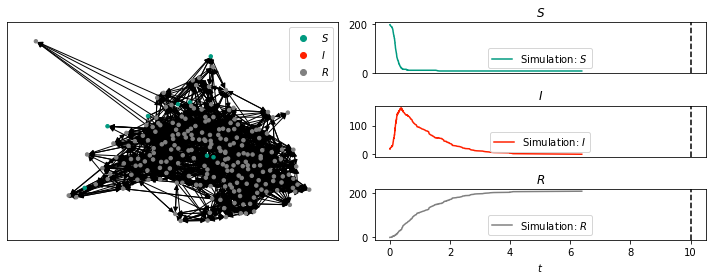

In [14]:
pos=nx.spring_layout(G, k=0.6, iterations=100)
sir_data.set_pos(pos)
sir_data.display(10, node_size=12)
plt.show()

## SIS

In [15]:
# Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/examples/SIS_display.html

In [16]:
gamma = 1. #recovery rate per node
tau = 0.1 #transmission rate per edge
sis_data = EoN.fast_SIS(G, tau, gamma, transmission_weight='weight', initial_infecteds=range(1,20), return_full_data=True)

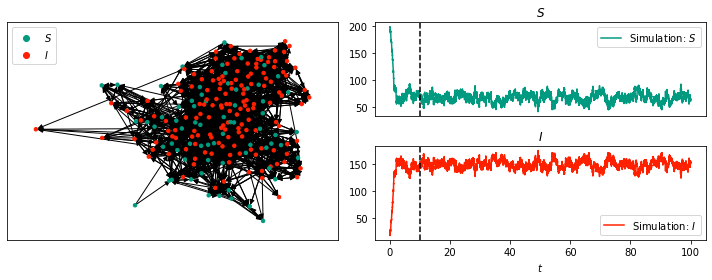

In [17]:
pos=nx.spring_layout(G, k=0.6, iterations=100)
sis_data.set_pos(pos)
sis_data.display(10, node_size=12)
plt.show()

## SIRS

In [18]:
#Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/examples/SIRS.html
#               https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.Gillespie_simple_contagion.html#EoN.Gillespie_simple_contagion

In [24]:
from collections import defaultdict

H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
H.add_edge('I', 'R', rate = 1.4)   #I->R
H.add_edge('R', 'S', rate = 0.2)   #R->S

J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
J.add_edge(('I', 'S'), ('I', 'I'), rate = 1, weight_label='weight')  #IS->II

IC = defaultdict(lambda: 'S')
for node in range(20):
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R')

sirs_data = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, return_full_data=True)



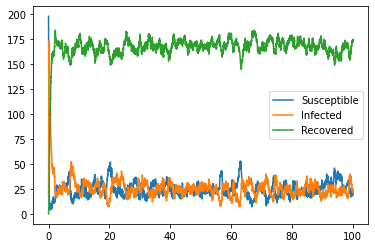

In [25]:
t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses)

plt.plot(t, S, label = 'Susceptible')
plt.plot(t, I, label = 'Infected')
plt.plot(t, R, label = 'Recovered')
plt.legend()

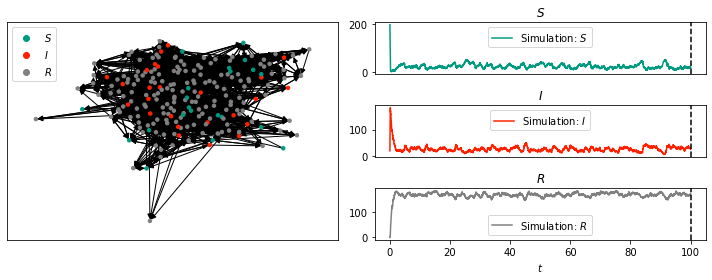

In [26]:
pos=nx.spring_layout(G, k=0.6, iterations=100)
sirs_data.set_pos(pos)
sirs_data.display(100, node_size=12)
plt.show()